In [73]:
import os
import copy
import glob
import subprocess

import slug

# Set up matplotlib and use a nicer set of plot parameters
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import sep

import numpy as np

from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table, Column
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

from kungpao.display import display_single, IMG_CMAP, SEG_CMAP
from kungpao import imtools

from tractor import NullWCS, NullPhotoCal, ConstantSky
from tractor.galaxy import *
from tractor.sersic import *
from tractor.psf import *
from tractor.ellipses import *

%matplotlib inline

## Import image file

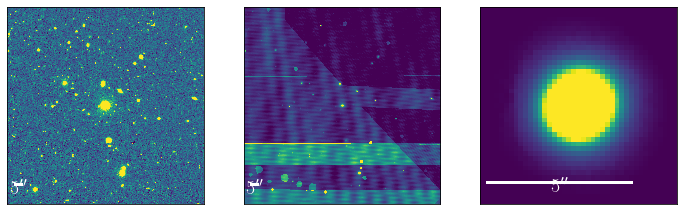

In [316]:
img = fits.open('./cutout-HSC-R-8762-s18a_wide-181211-205947.fits')
w = WCS(img[1].header)

img_data = img[1].data
variance = img[3].data
invvar = (1.0/(variance**2.0))

psf_data = fits.open('psf-calexp-s18a_wide-HSC-R-9071-4,4-129.42149--2.23140.fits')[0].data
psf_obj = PixelizedPSF(psf_data, Lorder=3)

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0] = display_single(img_data, ax=ax[0])
ax[1] = display_single(variance, ax=ax[1])
ax[2] = display_single(psf_data, ax=ax[2])

In [315]:
w.wcs_pix2world(img_data.shape[0]/2, img_data.shape[1]/2, 1)

[array(129.57404781), array(-1.63548732)]

In [181]:
# Change the byteorder (translate the bytes)
img_data = img_data.byteswap().newbyteorder()

# Detect 37 objects


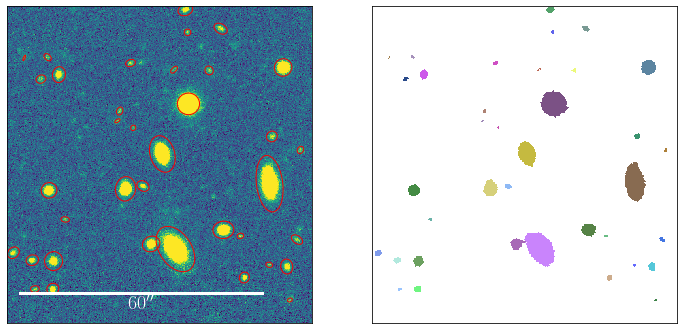

In [261]:
obj_table, segmap = slug.extract_obj(img_data, sigma=3)

#### Save the shapes and positions to a `fits` file

In [312]:
pixel_scale = slug.HSC_pixel_scale
#get world coordinate system from header and scale pixels to WCS
img_wcs = w

#get the arcsec length of major/minor axes
a_arcsec, b_arcsec = (pixel_scale * obj_table['a']), (pixel_scale * obj_table['b']) 


x = obj_table['x']
y = obj_table['y']
ra, dec = w.wcs_pix2world(zip(x,y),1).T
x2 = obj_table['x2']
y2 = obj_table['y2']
xy = obj_table['xy']
a = obj_table['a'] # pixel
b = obj_table['b'] # pixel
theta = obj_table['theta']
flux = obj_table['flux']

point_source = [((b_arcsec[i]/ a_arcsec[i] > .9) and (a_arcsec[i]<.35)) for i in range(len(obj_table))]

t = Table([ra, dec, x, y, x2, y2, xy, a, b, a_arcsec, b_arcsec, theta, flux, point_source], 
          names=('ra', 'dec', 'x', 'y', 'x2','y2','xy', 'a', 'b', 
                 'a_arcsec','b_arcsec','theta','flux','point_source'), 
          meta={'name': 'object table'})

if False: # Not write to fits file
    #step 7
    tbhdu = fits.BinTableHDU.from_columns(
         [fits.Column(name='ra', format='D', array=np.array(ra)),
          fits.Column(name='dec', format='D', array=np.array(dec)),
          fits.Column(name='x', format='D', array=np.array(x)),
          fits.Column(name='y', format='D', array=np.array(y)),
          fits.Column(name='x2', format = 'D', array=np.array(x2)),
          fits.Column(name='y2', format = 'D', array=np.array(y2)),
          fits.Column(name='xy', format = 'D', array=np.array(xy)),
          fits.Column(name='a', format = 'D', array=np.array(a)),
          fits.Column(name='b', format = 'D', array=np.array(b)),
          fits.Column(name='theta', format = 'D', array=np.array(theta)),
          fits.Column(name='flux', format = 'D', array=np.array(flux)),
          fits.Column(name='point_source', format = 'L', array=np.array(point_source))])

    output_filename = 'test_source_HSC.fits'
    if np.any(np.array(glob.glob('*'))==output_filename):
        subprocess.Popen('rm ' + output_filename, shell = True)
        tbhdu.writeto(output_filename)
    else: 
        tbhdu.writeto(output_filename)
    

### Match these galaxies with DECaLS tractor file and get their type

In [263]:
from astropy.coordinates import match_coordinates_sky
from astropy import units as u
from astropy.coordinates import SkyCoord

In [264]:
#bkg_pos = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
decals_cat = Table.read('./DECaLS_cat.fits', format='fits')
decals_catalog = SkyCoord(ra=np.array(decals_cat['ra'])*u.degree, dec=np.array(decals_cat['dec'])*u.degree)
measure_catalog = SkyCoord(ra=t['ra']*u.degree, dec=t['dec']*u.degree)

In [265]:
temp = decals_cat[match_coordinates_sky(measure_catalog, decals_catalog)[0]]

In [266]:
for columns in temp.columns:
    t.add_column(temp[columns], rename_duplicate=True)
obj_cat = t

In [267]:
obj_type = np.array(map(lambda st: st.rstrip(' '), obj_cat['type']))
comp_galaxy = obj_cat[obj_type == 'COMP']
dev_galaxy = obj_cat[obj_type == 'DEV']
exp_galaxy = obj_cat[obj_type == 'EXP']
rex_galaxy = obj_cat[obj_type == 'REX']
psf_galaxy = obj_cat[np.logical_or(obj_type =='PSF', obj_type=='   ')]

## Select sources from DECaLS tractor file: we use DECaLS type, but use the shapes measured by ourselves.
> for obj in comp_galaxy:
    if obj['flux_r']>20:
        pos_x, pos_y = w.wcs_world2pix([[obj['ra'], obj['dec']]],1)[0]
        sources.append(FixedCompositeGalaxy(PixPos(pos_x, pos_y),
                         Flux(obj['flux_r']),
                         obj['fracdev'],
                         EllipseE(obj['shapeexp_r'], obj['shapeexp_e1'], obj['shapeexp_e2']),
                         EllipseE(obj['shapedev_r'], obj['shapedev_e1'], obj['shapedev_e2'])))

In [287]:
# Using manually measured shapes
sources = []
for obj in comp_galaxy:
    pos_x, pos_y = w.wcs_world2pix([[obj['ra'], obj['dec']]], 1)[0]
    sources.append(
        CompositeGalaxy(
            PixPos(pos_x, pos_y), Flux(0.4 * obj['flux']),
            GalaxyShape(obj['a_arcsec'] * 0.8, 0.9,
                        90.0 + obj['theta'] * 180.0 / np.pi),
            Flux(0.6 * obj['flux']),
            GalaxyShape(obj['a_arcsec'], obj['b_arcsec'] / obj['a_arcsec'],
                        90.0 + obj['theta'] * 180.0 / np.pi)))
for obj in dev_galaxy:
    pos_x, pos_y = w.wcs_world2pix([[obj['ra'], obj['dec']]], 1)[0]
    sources.append(
        DevGalaxy(
            PixPos(pos_x, pos_y), Flux(obj['flux']),
            GalaxyShape(obj['a_arcsec'], (obj['b_arcsec'] / obj['a_arcsec']),
                        (90.0 + obj['theta'] * 180.0 / np.pi))))
for obj in exp_galaxy:
    pos_x, pos_y = w.wcs_world2pix([[obj['ra'], obj['dec']]], 1)[0]
    sources.append(
        ExpGalaxy(
            PixPos(pos_x, pos_y), Flux(obj['flux']),
            GalaxyShape(obj['a_arcsec'], (obj['b_arcsec'] / obj['a_arcsec']),
                        (90.0 + obj['theta'] * 180.0 / np.pi))))
for obj in rex_galaxy:
    pos_x, pos_y = w.wcs_world2pix([[obj['ra'], obj['dec']]], 1)[0]
    sources.append(
        ExpGalaxy(
            PixPos(pos_x, pos_y), Flux(obj['flux']),
            GalaxyShape(obj['a_arcsec'], (obj['b_arcsec'] / obj['a_arcsec']),
                        (90.0 + obj['theta'] * 180.0 / np.pi))))
for obj in psf_galaxy:
    pos_x, pos_y = w.wcs_world2pix([[obj['ra'], obj['dec']]], 1)[0]
    sources.append(PointSource(PixPos(pos_x, pos_y), Flux(obj['flux'])))

len(sources)

37

In [298]:
## Using DECaLS shapes
sources = []
for obj in comp_galaxy:
    pos_x, pos_y = w.wcs_world2pix([[obj['ra'], obj['dec']]], 1)[0]
    sources.append(
        CompositeGalaxy(
            PixPos(pos_x, pos_y), Flux(0.4 * obj['flux']),
            EllipseE(obj['shapeexp_r'], obj['shapeexp_e1'],
                     obj['shapeexp_e2']), Flux(0.6 * obj['flux']),
            EllipseE(obj['shapedev_r'], obj['shapedev_e1'],
                     obj['shapedev_e2'])))
for obj in dev_galaxy:
    pos_x, pos_y = w.wcs_world2pix([[obj['ra'], obj['dec']]], 1)[0]
    sources.append(
        DevGalaxy(
            PixPos(pos_x, pos_y), Flux(obj['flux']),
            EllipseE(obj['shapedev_r'], obj['shapedev_e1'],
                     -obj['shapedev_e2'])))
for obj in exp_galaxy:
    pos_x, pos_y = w.wcs_world2pix([[obj['ra'], obj['dec']]], 1)[0]
    sources.append(
        ExpGalaxy(
            PixPos(pos_x, pos_y), Flux(obj['flux']),
            EllipseE(obj['shapeexp_r'], obj['shapeexp_e1'],
                     -obj['shapeexp_e2'])))
for obj in rex_galaxy:
    #if obj['point_source'] > 0.0:
    #            sources.append(PointSource(PixPos(w.wcs_world2pix([[obj['ra'], obj['dec']]],1)[0]),
    #                                               Flux(obj['flux'])))
    pos_x, pos_y = w.wcs_world2pix([[obj['ra'], obj['dec']]], 1)[0]
    sources.append(
        ExpGalaxy(
            PixPos(pos_x, pos_y), Flux(obj['flux']),
            EllipseE(obj['shapeexp_r'], obj['shapeexp_e1'],
                     -obj['shapeexp_e2'])))

for obj in psf_galaxy:
    pos_x, pos_y = w.wcs_world2pix([[obj['ra'], obj['dec']]], 1)[0]
    sources.append(PointSource(PixPos(pos_x, pos_y), Flux(obj['flux'])))

len(sources)

37

## Construct tractor image

In [299]:
tim = Image(data=img_data,
            invvar=invvar,
            psf=psf_obj,
            wcs=NullWCS(pixscale=slug.HSC_pixel_scale),
            sky=ConstantSky(0.0),
            photocal=NullPhotoCal()
            )

In [300]:
trac_obj = Tractor([tim], sources)
trac_mod = trac_obj.getModelImage(0, minsb=0.0)

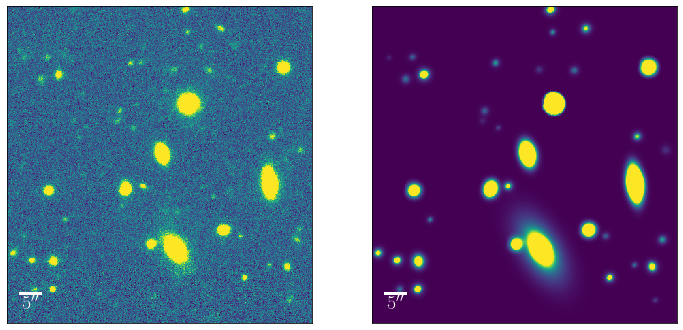

In [301]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,6))
ax1 = display_single(img_data, ax=ax1)
ax2 = display_single(trac_mod, ax=ax2, contrast=0.01)

## Fit tractor

In [302]:
trac_obj.freezeParam('images')
#trac_obj.thawParam('images')
trac_obj.optimize_loop()


trac_mod_opt = trac_obj.getModelImage(0, minsb=0., srcs=sources)

In [ ]:
'''for i in range(10):
    dlnp, X, alpha = trac_obj.optimize()
    print 'dlnp', dlnp
    if dlnp < 1e-5:
        break
'''

Text(0.5,1,'residual')

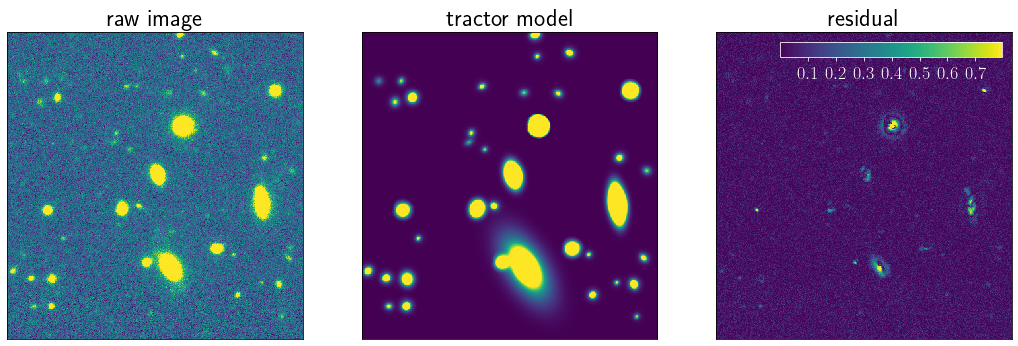

In [310]:
plt.rc('font', size=20)
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(18,6))
ax1 = display_single(img_data, ax=ax1, scale_bar=False)
ax1.set_title('raw image')
ax2 = display_single(trac_mod_opt, ax=ax2, scale_bar=False, contrast=0.02)
ax2.set_title('tractor model')
ax3 = display_single(abs(img_data - trac_mod_opt), ax=ax3, scale_bar=False, color_bar=True, contrast=0.05)
ax3.set_title('residual')

In [311]:
# Chi-square
np.sqrt(np.mean(np.square((img_data - trac_mod_opt).flatten())))

0.100354485